<a href="https://colab.research.google.com/github/Niteeshmohan/Projectwork1/blob/main/An_AI_Driven_Ensemble_Framework_for_Forecasting_Essential_Commodity_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima.model import ARIMA   # <-- replaces pmdarima
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt # Add this to your import list


# ==============================
# 1. Load Dataset  (FILEPATH ADDED)
# ==============================
FILEPATH = "/content/dataset.xlsx"   # ← your file

df = pd.read_excel(FILEPATH)

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"])


# ==============================
# 2. Commodity List
# ==============================
COMMODITY_LIST = [
    "Rice","Wheat","Atta (Wheat)","Gram Dal","Tur/Arhar Dal","Urad Dal",
    "Moong Dal","Masoor Dal","Sugar","Milk @","Groundnut Oil (Packed)",
    "Mustard Oil (Packed)","Vanaspati (Packed)","Soya Oil (Packed)",
    "Sunflower Oil (Packed)","Palm Oil (Packed)","Gur","Tea Loose",
    "Salt Pack (Iodised)","Potato","Onion","Tomato"
]


# ==============================
# 3. Prepare Series
# ==============================
def prepare_series(df, state, commodity):
    temp = df[df["States/UTs"] == state][["Date", commodity]].copy()

    if temp.empty:
        raise ValueError("No data for this state.")

    # Remove duplicates safely: group by date and average the values
    temp = temp.groupby("Date").mean().reset_index()

    temp = temp.rename(columns={commodity: "y"})
    temp = temp.set_index("Date").sort_index()

    # Fill missing dates
    idx = pd.date_range(temp.index.min(), temp.index.max(), freq="D")
    temp = temp.reindex(idx)
    temp["y"] = temp["y"].ffill().bfill()

    return temp["y"]



# ==============================
# 4. ARIMA (statsmodels version)
# ==============================
def arima_predict(series, future_days):
    try:
        model = ARIMA(series, order=(5,1,0))
        fitted = model.fit()
        forecast = fitted.forecast(steps=future_days)
        return float(forecast.iloc[-1])
    except:
        return float(series.iloc[-1])


# ==============================
# 5. Prophet Prediction
# ==============================
def prophet_predict(series, future_days):
    df_p = series.reset_index()
    df_p.columns = ["ds", "y"]

    try:
        model = Prophet(daily_seasonality=True, yearly_seasonality=True)
        model.fit(df_p)
        future = model.make_future_dataframe(periods=future_days)
        fc = model.predict(future)
        return float(fc["yhat"].iloc[-1])
    except:
        return float(series.iloc[-1])


# ==============================
# 6. LSTM Prediction
# ==============================
def lstm_predict(series, future_days, seq_len=30):
    arr = series.values.astype(float)

    if len(arr) < seq_len + 10:
        return float(arr[-1])

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(arr.reshape(-1,1)).flatten()

    X, y = [], []
    for i in range(len(scaled) - seq_len):
        X.append(scaled[i:i+seq_len])
        y.append(scaled[i+seq_len])

    X = np.array(X).reshape(-1, seq_len, 1)
    y = np.array(y)

    model = Sequential([
        LSTM(64, input_shape=(seq_len,1)),
        Dense(32, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")

    model.fit(X, y, epochs=20, batch_size=16, verbose=0,
              callbacks=[EarlyStopping(monitor="loss", patience=5)])

    # rolling forecast
    last_seq = scaled[-seq_len:].reshape(1, seq_len, 1)

    for _ in range(future_days):
        p = model.predict(last_seq, verbose=0)[0][0]
        last_seq = np.roll(last_seq, -1)
        last_seq[0, -1, 0] = p

    final_value = scaler.inverse_transform([[last_seq[0,-1,0]]])[0][0]
    return float(final_value)


# ==============================
# 7. MASTER FUNCTION
# ==============================
def predict_price(state, commodity, future_date):
    if commodity not in COMMODITY_LIST:
        raise ValueError("Invalid commodity.")

    series = prepare_series(df, state, commodity)

    last_date = series.index.max()
    future_date = pd.to_datetime(future_date)

    if future_date <= last_date:
        raise ValueError("Prediction date must be AFTER dataset end.")

    future_days = (future_date - last_date).days

    a = arima_predict(series, future_days)
    p = prophet_predict(series, future_days)
    l = lstm_predict(series, future_days)

    ensemble = (a + p + l) / 3

    return {
        "State": state,
        "Commodity": commodity,
        "Predicted Date": str(future_date.date()),
        "ARIMA": a,
        "Prophet": p,
        "LSTM": l,
        "Final Ensemble Price": ensemble
    }


# ==============================
# 8. USER INPUT
# ==============================
if __name__ == "__main__":
    print("\n=== PRICE PREDICTOR ===\n")

    state = input("Enter State/UT: ")
    commodity = input("Enter Commodity Name: ")
    d = input("Enter future date (YYYY-MM-DD): ")

    out = predict_price(state, commodity, d)

    print("\n=== RESULT ===")
    for k, v in out.items():
        print(f"{k}: {v}")


=== PRICE PREDICTOR ===

Enter State/UT: Tamil Nadu
Enter Commodity Name: Rice
Enter future date (YYYY-MM-DD): 2025-11-21

=== RESULT ===
State: Tamil Nadu
Commodity: Rice
Predicted Date: 2025-11-21
ARIMA: 55.37122965425048
Prophet: 55.21833955999517
LSTM: 55.14543846771121
Final Ensemble Price: 55.24500256065229


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def calculate_metrics(actual, predicted):
    """
    Calculates Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE).
    """
    if len(actual) == 0:
        return {"MSE": np.nan, "RMSE": np.nan, "MAE": np.nan}

    # MSE (Mean Squared Error)
    mse = mean_squared_error(actual, predicted)

    # RMSE (Root Mean Squared Error)
    rmse = sqrt(mean_squared_error(actual, predicted))

    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(actual, predicted)

    return {"RMSE": rmse, "MAE": mae}
# ==============================
# 9. EVALUATION FUNCTION (BACKTESTING)
# ==============================
def evaluate_models(state, commodity, test_days=30):
    if commodity not in COMMODITY_LIST:
        raise ValueError("Invalid commodity.")

    series = prepare_series(df, state, commodity)

    # Check if series is long enough for backtesting
    if len(series) <= test_days:
        raise ValueError(f"Not enough data for backtesting with {test_days} days.")

    # --- Train-Test Split (Backtesting) ---
    # Train on past data, test on recent data
    train_series = series.iloc[:-test_days]
    test_series = series.iloc[-test_days:]
    actual_values = test_series.values

    # Placeholder for predictions
    arima_predictions = np.zeros(test_days)
    prophet_predictions = np.zeros(test_days)
    lstm_predictions = np.zeros(test_days)

    # Get the last known training value for simple baselining if a model fails
    last_train_val = train_series.iloc[-1]

    # 1. ARIMA Prediction
    try:
        model_arima = ARIMA(train_series, order=(5,1,0))
        fitted_arima = model_arima.fit()
        forecast_arima = fitted_arima.forecast(steps=test_days)
        arima_predictions = forecast_arima.values
    except Exception as e:
        # print(f"Warning: ARIMA failed, using last value baseline. Error: {e}")
        arima_predictions = np.full(test_days, last_train_val)


    # 2. Prophet Prediction
    try:
        df_p = train_series.reset_index()
        df_p.columns = ["ds", "y"]
        model_prophet = Prophet(daily_seasonality=True, yearly_seasonality=True)
        model_prophet.fit(df_p)
        future = model_prophet.make_future_dataframe(periods=test_days)
        fc = model_prophet.predict(future)
        prophet_predictions = fc["yhat"].iloc[-test_days:].values
    except Exception as e:
        # print(f"Warning: Prophet failed, using last value baseline. Error: {e}")
        prophet_predictions = np.full(test_days, last_train_val)


    # 3. LSTM Prediction
    lstm_history = None  # Initialize to capture history safely
    try:
        seq_len = 30
        arr = train_series.values.astype(float)

        if len(arr) < seq_len + 10:
             raise ValueError("Training data too short for LSTM sequence.")

        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(arr.reshape(-1,1)).flatten()

        X_train, y_train = [], []
        for i in range(len(scaled) - seq_len):
            X_train.append(scaled[i:i+seq_len])
            y_train.append(scaled[i+seq_len])

        X_train = np.array(X_train).reshape(-1, seq_len, 1)
        y_train = np.array(y_train)

        model_lstm = Sequential([
            LSTM(64, input_shape=(seq_len,1)),
            Dense(32, activation="relu"),
            Dense(1)
        ])
        model_lstm.compile(optimizer="adam", loss="mse")

        # --- MODIFIED LINE START ---
        history = model_lstm.fit(
            X_train, y_train,
            epochs=50,               # Increased epochs to see training progress
            batch_size=16,
            verbose=0,
            validation_split=0.2,    # Reserve 20% of data for the validation curve
            callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)]
        )
        lstm_history = history.history # Capture the loss values
        # --- MODIFIED LINE END ---

        lstm_scaled_predictions = []
        current_seq = scaled[-seq_len:].reshape(1, seq_len, 1)

        for _ in range(test_days):
            p = model_lstm.predict(current_seq, verbose=0)[0][0]
            lstm_scaled_predictions.append(p)
            current_seq = np.roll(current_seq, -1)
            current_seq[0, -1, 0] = p

        lstm_predictions = scaler.inverse_transform(np.array(lstm_scaled_predictions).reshape(-1,1)).flatten()

    except Exception as e:
        lstm_predictions = np.full(test_days, last_train_val)

    # 4. Ensemble Prediction (Simple Average)
    ensemble_predictions = (arima_predictions + prophet_predictions + lstm_predictions) / 3

    # --- Calculate Metrics ---
    metrics_arima = calculate_metrics(actual_values, arima_predictions)
    metrics_prophet = calculate_metrics(actual_values, prophet_predictions)
    metrics_lstm = calculate_metrics(actual_values, lstm_predictions)
    metrics_ensemble = calculate_metrics(actual_values, ensemble_predictions)

    return {
        "State": state,
        "Commodity": commodity,
        "Test Period (Days)": test_days,
        "ARIMA": metrics_arima,
        "Prophet": metrics_prophet,
        "LSTM": metrics_lstm,
        "Ensemble": metrics_ensemble,
        # Return data for plotting in the execution block
        "Actual Values": actual_values.tolist(),
        "Ensemble Predictions": ensemble_predictions.tolist(),
        "LSTM_History": lstm_history
    }


=== PRICE PREDICTOR ===

Enter State/UT: Tamil Nadu
Enter Commodity Name: Tomato
Enter future date for prediction (YYYY-MM-DD): 2025-11-21

=== PREDICTION RESULT ===
State: Tamil Nadu
Commodity: Tomato
Predicted Date: 2025-11-21
ARIMA: 30.846204540167214
Prophet: 27.801840527896754
LSTM: 31.143039250373842
Final Ensemble Price: 29.93036143947927

--- RUNNING ACCURACY TEST (BACKTESTING) ---
Enter number of historical days to test (e.g., 30): 20

=== ACCURACY EVALUATION RESULTS (20 Days) ===

| Model | MSE | RMSE | MAE |
|:---:|:---:|:---:|:---:|
| ARIMA | 47.405 | 6.885 | 4.963 |
| Prophet | 303.292 | 17.415 | 15.120 |
| LSTM | 69.076 | 8.311 | 6.233 |
| Ensemble | 42.192 | 6.496 | 6.261 |

--- GENERATING PLOT ---


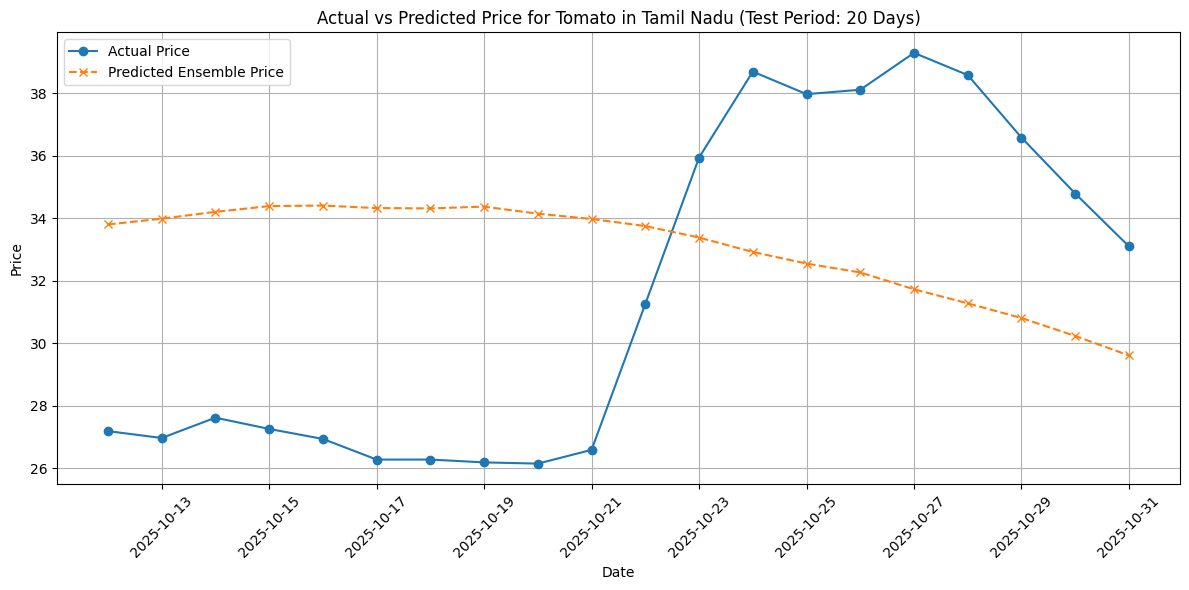


--- GENERATING LSTM LOSS & VALIDATION CURVES ---


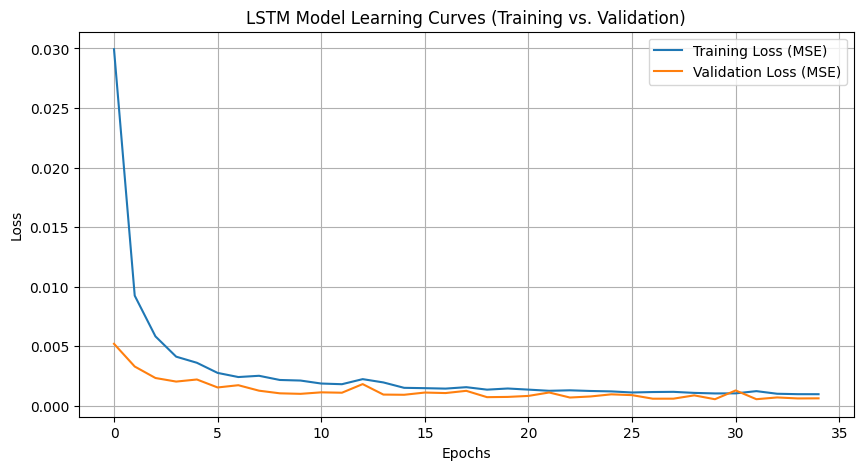

In [ ]:
# ==============================
# 10. USER INPUT / EXECUTION (FINAL FIXED VERSION)
# ==============================

import numpy as np
import matplotlib.pyplot as plt


def plot_lstm_loss(history_dict):
    """Plots the training and validation loss from the LSTM history."""
    if history_dict:
        plt.figure(figsize=(10, 5))
        plt.plot(history_dict['loss'], label='Training Loss (MSE)')
        plt.plot(history_dict['val_loss'], label='Validation Loss (MSE)')
        plt.title('LSTM Model Learning Curves (Training vs. Validation)')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("\n[Note] LSTM Loss plot not available (LSTM may have skipped or failed).")


def get_metric(out_eval, model, key):
    """Safely fetch metric value"""
    return out_eval.get(model, {}).get(key, float('nan'))


if __name__ == "__main__":

    print("\n=== PRICE PREDICTOR ===\n")

    state = input("Enter State/UT: ")
    commodity = input("Enter Commodity Name: ")

    try:
        # -------------------------------------------------
        # 1. FUTURE PRICE PREDICTION
        # -------------------------------------------------
        d = input("Enter future date for prediction (YYYY-MM-DD): ")
        out_predict = predict_price(state, commodity, d)

        print("\n=== PREDICTION RESULT ===")
        for k, v in out_predict.items():
            print(f"{k}: {v}")

        # -------------------------------------------------
        # 2. BACKTESTING / ACCURACY EVALUATION
        # -------------------------------------------------
        print("\n--- RUNNING ACCURACY TEST (BACKTESTING) ---")
        test_days = int(input("Enter number of historical days to test (e.g., 30): "))

        out_eval = evaluate_models(state, commodity, test_days=test_days)

        print(f"\n=== ACCURACY EVALUATION RESULTS ({test_days} Days) ===")

        # -------------------------------------------------
        # 3. METRICS TABLE (MSE FIXED)
        # -------------------------------------------------
        print("\n| Model | MSE | RMSE | MAE |")
        print("|:---:|:---:|:---:|:---:|")

        for model in ["ARIMA", "Prophet", "LSTM", "Ensemble"]:
            rmse = get_metric(out_eval, model, "RMSE")
            mae = get_metric(out_eval, model, "MAE")
            mse = rmse ** 2 if not np.isnan(rmse) else float('nan')

            print(f"| {model} | {mse:.3f} | {rmse:.3f} | {mae:.3f} |")

        # -------------------------------------------------
        # 4. ACTUAL vs PREDICTED PRICE PLOT
        # -------------------------------------------------
        print("\n--- GENERATING PLOT ---")

        actual_values = out_eval.get("Actual Values")
        predicted_values = out_eval.get("Ensemble Predictions")

        if actual_values is not None and predicted_values is not None:

            series = prepare_series(df, state, commodity)
            test_dates = series.index[-test_days:]

            plt.figure(figsize=(12, 6))

            plt.plot(
                test_dates,
                actual_values,
                label="Actual Price",
                marker="o",
                linestyle="-"
            )

            plt.plot(
                test_dates,
                predicted_values,
                label="Predicted Ensemble Price",
                marker="x",
                linestyle="--"
            )

            plt.title(
                f"Actual vs Predicted Price for {commodity} in {state} "
                f"(Test Period: {test_days} Days)"
            )
            plt.xlabel("Date")
            plt.ylabel("Price")
            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

        else:
            print("[Warning] Plot data not available.")

        # -------------------------------------------------
        # 5. LSTM LOSS & VALIDATION CURVES
        # -------------------------------------------------
        print("\n--- GENERATING LSTM LOSS & VALIDATION CURVES ---")
        plot_lstm_loss(out_eval.get("LSTM_History"))

    except ValueError as e:
        print(f"\nERROR: {e}")

    except Exception as e:
        print(f"\nAn unexpected error occurred during execution: {e}")
